# Sprint21 自然言語処理

## データのダウンロード

In [2]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2021-09-10 16:38:22--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  38.8MB/s    in 2.1s    

2021-09-10 16:38:24 (38.8 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include 

## データの読み込み

In [3]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [4]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


## BoW

In [5]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

print(mini_dataset)

['This movie is very good.', 'This film is a good', 'Very bad. Very, very bad.']


In [6]:
mini_dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


## n-gram

In [8]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


## 【問題1】BoWのスクラッチ実装
---
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

In [9]:
import numpy as np
import pandas as pd
import re

# 2-gram
def get_unigram(data):

    # すべての文字列を小文字に変換
    lower_dataset = list(map(str.lower, data))

    unigram_list = []
    for words in lower_dataset:
        unigram_list.append(re.findall(r'(?u)\b\w+\b', words))

    temp = np.concatenate(unigram_list).tolist()
    word_unique = list(set(temp))

    # 結果を格納するDataFrameを初期化
    df = pd.DataFrame(index=range(len(lower_dataset)), columns=word_unique)

    # 各文章に単語が何回登場するかをカウントする
    for idx, sentence in enumerate(unigram_list):
        for token in word_unique:
            df.loc[idx, token] = sentence.count(token)

    return df

# 1-gram
def get_bigram(data):

    # すべての文字列を小文字に変換
    lower_dataset = list(map(str.lower, data))

    n = 2
    unigram_list = []
    for words in lower_dataset:
        seq = re.findall(r'(?u)\b\w+\b', words)
        unigram_list.append([seq[i] + " " + seq[i+n-1] for i in range(len(seq)-n+1)])

    temp = np.concatenate(unigram_list).tolist()
    word_unique = list(set(temp))
    
    # 結果を格納するDataFrameを初期化
    df = pd.DataFrame(index=range(len(lower_dataset)), columns=word_unique)

    # 各文章に単語が何回登場するかをカウントする
    for idx, sentence in enumerate(unigram_list):
        for token in word_unique:
            df.loc[idx, token] = sentence.count(token)

    return df


In [10]:

sample_dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

print("sample_dataset : \n")
display(sample_dataset)
print("1-gram:\n")
display(get_unigram(sample_dataset))
print("2-gram:\n")
display(get_bigram(sample_dataset))

sample_dataset : 



['This movie is SOOOO funny!!!',
 'What a movie! I never',
 'best movie ever!!!!! this movie']

1-gram:



,movie,is,never,a,soooo,this,i,funny,ever,best,what
0,1,1,0,0,1,1,0,1,0,0,0
1,1,0,1,1,0,0,1,0,0,0,1
2,2,0,0,0,0,1,0,0,1,1,0


2-gram:



,what a,best movie,is soooo,movie is,ever this,movie ever,i never,this movie,movie i,a movie,soooo funny
0,0,0,1,1,0,0,0,1,0,0,1
1,1,0,0,0,0,0,1,0,1,1,0
2,0,1,0,0,1,1,0,1,0,0,0


## TF-IDF

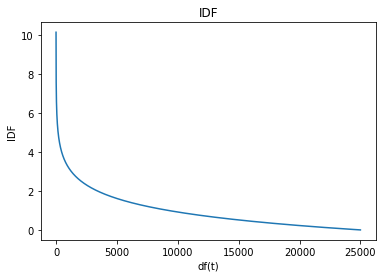

In [11]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

## ストップワード

In [12]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,movie,never,soooo,this,what
0,0,0,0,1,0,1,0,1,1,0
1,1,0,0,0,1,1,1,0,0,1
2,0,1,1,0,0,2,0,0,1,0


In [13]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all'

In [14]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,movie,this
0,0,0,0,1,1
1,1,0,0,1,0
2,0,1,1,2,1


## 【問題2】TF-IDFの計算
---
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

print(len(stop_words))
# TF-IDFの計算
vectorizer = TfidfVectorizer(use_idf=True, stop_words=stop_words, norm=None, max_features=5000)
tfidf_matrix = vectorizer.fit_transform(x_train)

179


In [16]:
train_size= len(x_train)
print(train_size)
print("IMDB映画レビューデータセットの数：", len(x_train))
print("TF-IDFのShape：\n", tfidf_matrix.shape)
print("TF-IDFの計算結果：\n", tfidf_matrix)

# 単語リストの取得
terms = vectorizer.get_feature_names()
print('単語リスト：\n%s' % ' '.join(terms))

# TF-IDFの表示
print("TF-IDFの表示:\n", tfidf_matrix.toarray())

a = tfidf_matrix[:train_size,:]
display(a)

25000
IMDB映画レビューデータセットの数： 25000
TF-IDFのShape：
 (25000, 5000)
TF-IDFの計算結果：
   (0, 2158)	6.5519601245469765
  (0, 4444)	3.929235748953768
  (0, 2156)	5.008573905009011
  (0, 1769)	6.136238516271623
  (0, 3884)	2.1272987064582525
  (0, 2609)	5.117857917607764
  (0, 267)	3.279690120911571
  (0, 201)	3.2409657118073394
  (0, 1670)	6.561727200825109
  (0, 4045)	5.8536715444866125
  (0, 1920)	3.256887200520213
  (0, 1734)	3.1677330317010046
  (0, 1459)	6.769962276360768
  (0, 475)	5.3744465205179495
  (0, 111)	5.481224205407122
  (0, 2932)	6.541703624379787
  (0, 1606)	6.453842268588453
  (0, 4443)	10.275419372320991
  (0, 3436)	5.733043556697997
  (0, 3635)	5.4847640321122455
  (0, 114)	2.9318894646070004
  (0, 1737)	5.491881499881109
  (0, 4515)	2.051577880482202
  (0, 2907)	3.5424062846613
  (0, 1933)	3.728497010079894
  :	:
  (24999, 3233)	2.3906637184811412
  (24999, 902)	6.724750193199682
  (24999, 2053)	4.244233632052512
  (24999, 1739)	5.381809820659702
  (24999, 2708)	2.3671593809338

<25000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1999647 stored elements in Compressed Sparse Row format>

## 【問題3】TF-IDFを用いた学習
---
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。

ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

In [19]:
print(y_train)

[1 0 1 ... 0 0 0]


In [22]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=2, random_state=0).fit_predict(tfidf_matrix)

In [26]:
model = KMeans(n_clusters=2, random_state=0)
clusters = model.fit(tfidf_matrix)


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_test, clusters))
print('accuracy = ', accuracy_score(y_test, clusters))
print('precision = ', precision_score(y_test, clusters))
print('recall = ', recall_score(y_test, clusters))
print('f1 score = ', f1_score(y_test, clusters))

confusion matrix = 
 [[10049  2451]
 [10014  2486]]
accuracy =  0.5014
precision =  0.5035446627506583
recall =  0.19888
f1 score =  0.28514079256752883


## 最大の語彙数やストップワード、n-gramの数を変化

In [32]:
vectorizer2 = TfidfVectorizer(use_idf=True, stop_words=stop_words[:100], norm=None, max_features=2000)
tfidf_matrix2 = vectorizer2.fit_transform(x_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 're', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [33]:
clusters2 = KMeans(n_clusters=2, random_state=0).fit_predict(tfidf_matrix2)
model2 = KMeans(n_clusters=2, random_state=0)
res = model2.fit(tfidf_matrix2)

In [34]:
print('confusion matrix = \n', confusion_matrix(y_test, clusters2))
print('accuracy = ', accuracy_score(y_test, clusters2))
print('precision = ', precision_score(y_test, clusters2))
print('recall = ', recall_score(y_test, clusters2))
print('f1 score = ', f1_score(y_test, clusters2))

confusion matrix = 
 [[ 2464 10036]
 [ 2425 10075]]
accuracy =  0.50156
precision =  0.5009696186166774
recall =  0.806
f1 score =  0.6178896691300482


## 問題4】TF-IDFのスクラッチ実装
---
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

In [33]:
sample_dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

In [34]:
vectorizer = TfidfVectorizer(use_idf=True, norm=None)
tfidf_matrix = vectorizer.fit_transform(sample_dataset)
print("TF-IDFの計算結果：\n", tfidf_matrix)
print(tfidf_matrix.toarray())
print(tfidf_matrix.shape)

terms = vectorizer.get_feature_names()
print('単語リスト：\n%s' % ' '.join(terms))

TF-IDFの計算結果：
   (0, 2)	1.6931471805599454
  (0, 6)	1.6931471805599454
  (0, 3)	1.6931471805599454
  (0, 4)	1.0
  (0, 7)	1.2876820724517808
  (1, 5)	1.6931471805599454
  (1, 8)	1.6931471805599454
  (1, 4)	1.0
  (2, 1)	1.6931471805599454
  (2, 0)	1.6931471805599454
  (2, 4)	2.0
  (2, 7)	1.2876820724517808
[[0.         0.         1.69314718 1.69314718 1.         0.
  1.69314718 1.28768207 0.        ]
 [0.         0.         0.         0.         1.         1.69314718
  0.         0.         1.69314718]
 [1.69314718 1.69314718 0.         0.         2.         0.
  0.         1.28768207 0.        ]]
(3, 9)
単語リスト：
best ever funny is movie never soooo this what


## コーディング

In [35]:
from math import log

def cal_tf(term, d, type='std'):
    if type == 'std':
        return d.count(term) / len(d)
    else:   # scikit-learn式
        return d.count(term)

def cal_idf(term, text, type='std'):
    N = len(text)

    df = 0
    for sentence in text:
        df += 1 if term in sentence else 0

    if type == 'std':
        return log(N/df)
    else:   # scikit-learn式
        return log((1+N)/(1+df)) + 1

def get_terms(data):

    terms_list = []
    for words in data:
        terms_list.append(re.findall(r'(?u)\b\w+\b', words))

    temp = np.concatenate(terms_list).tolist()
    terms = list(set(temp))

    return terms


def vectorizer_transform(text, type='std'):

    # すべての文字列を小文字に変換
    text = list(map(str.lower, text))

    terms = get_terms(text)

    # 各文章を単語ごとに区切る
    text = [re.findall(r'(?u)\b\w+\b', doc) for doc in text]

    # 結果を格納するDataFrameを初期化
    df = pd.DataFrame(index=range(len(text)), columns=terms)

    for idx, sentence in enumerate(text):
        for term in terms:
            tf = cal_tf(term, sentence, type=type)
            idf = cal_idf(term, text, type=type)
            df.loc[idx, term] = tf * idf

    return df


## TF-IDF: 標準式

In [36]:
df = vectorizer_transform(sample_dataset)
print(df)

      soooo     never         a     funny  ...      ever      this movie      best
0  0.219722         0         0  0.219722  ...         0  0.081093     0         0
1         0  0.219722  0.219722         0  ...         0         0     0         0
2         0         0         0         0  ...  0.219722  0.081093     0  0.219722

[3 rows x 11 columns]


## TF-IDF: scikit-learn式

In [37]:
df = vectorizer_transform(sample_dataset, type='sci')
print(df)

     soooo    never        a    funny  ...     ever     this movie     best
0  1.69315        0        0  1.69315  ...        0  1.28768     1        0
1        0  1.69315  1.69315        0  ...        0        0     1        0
2        0        0        0        0  ...  1.69315  1.28768     2  1.69315

[3 rows x 11 columns]


##  Word2Vec
---

In [38]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.01716001 -0.02113763 -0.00518383  0.02528845 -0.03232784  0.01879716
 -0.03925081 -0.04358804 -0.00272719  0.00494706]
movieのベクトル : 
[-0.04551527 -0.03639207 -0.04528041  0.03439375  0.00635951 -0.04683964
 -0.02692241 -0.04381145  0.0034478  -0.0393255 ]
isのベクトル : 
[-0.03230392  0.03372509 -0.03144509  0.00828235 -0.00411252  0.01623127
 -0.01772317 -0.0312591  -0.04581768 -0.00474703]
veryのベクトル : 
[ 0.04500676 -0.04042494 -0.02278136  0.03415778  0.03327113  0.0371672
 -0.02373589 -0.01525995  0.03184674  0.02293635]
goodのベクトル : 
[ 0.00557776  0.02444336  0.03659374  0.00978104  0.0204584  -0.0447748
 -0.00995882 -0.02273585 -0.0190124   0.03226217]
filmのベクトル : 
[-0.03880131 -0.00051494 -0.02937959 -0.01100396  0.01863867  0.00684971
  0.03958723 -0.04559601 -0.01672524 -0.01878948]
aのベクトル : 
[-0.03443953  0.03456135 -0.02402794 -0.04957069  0.03465991  0.03755327
 -0.02038728  0.03592424 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


### 単語の距離

In [39]:
model.wv.most_similar(positive="good", topn=3)

[('is', 0.0549154132604599),
 ('movie', -0.03326891362667084),
 ('this', -0.04271235316991806)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


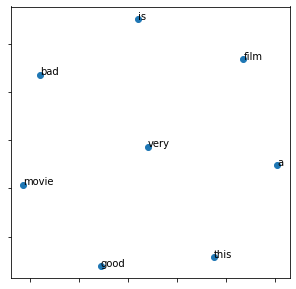

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## 【問題5】コーパスの前処理
---
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

In [41]:
x_train[38]

'I don\'t hand out "ones" often, but if there was ever a film that deserved this sort of attention, it\'s "Gas!" This is self-indulgent crap that reaches for some of the ambiance of M*A*S*H and falls completely flat on its face in the attempt.<br /><br />I see what Corman was going for - Malcolm Marmorstein and Elliott Gould tried to reproduce Gould\'s deathless role in the original movie version of M*A*S*H with a similar plot (in the movie "Whiffs" - look it up here in IMDb, http://www.imdb.com/title/tt0073891/ for more information).<br /><br />Marmorstein and Gould got closer to the brass ring with "Whiffs" than Corman did with "Gas!" but didn\'t quite get there. Neither one of those films even got close to the success of M*A*S*H.<br /><br />What\'s wrong with "Gas!"? What isn\'t? No one comes close to really acting at a level above junior high school theatrics. The production values stink. Someone else here mentioned the magically regenerating headlights on a getaway car, and there\

In [42]:
import re
# すべての文字列を小文字に変換
text1 = list(map(str.lower, x_train))
# htmlやURL関連の文字列を削除
text2 = [doc.replace('<br />', '') for doc in text1]
print(text2[38])
text3 = [re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', doc) for doc in text2]
print(text3[38])

i don't hand out "ones" often, but if there was ever a film that deserved this sort of attention, it's "gas!" this is self-indulgent crap that reaches for some of the ambiance of m*a*s*h and falls completely flat on its face in the attempt.i see what corman was going for - malcolm marmorstein and elliott gould tried to reproduce gould's deathless role in the original movie version of m*a*s*h with a similar plot (in the movie "whiffs" - look it up here in imdb, http://www.imdb.com/title/tt0073891/ for more information).marmorstein and gould got closer to the brass ring with "whiffs" than corman did with "gas!" but didn't quite get there. neither one of those films even got close to the success of m*a*s*h.what's wrong with "gas!"? what isn't? no one comes close to really acting at a level above junior high school theatrics. the production values stink. someone else here mentioned the magically regenerating headlights on a getaway car, and there's more of that lack of attention to detail.

In [43]:
# 各文章を単語ごとに区切る

text4 = [re.findall(r'(?u)\b\w+\b', doc) for doc in text3]
print(len(text4))

25000


## 【問題6】Word2Vecの学習
---
Word2Vecの学習を行なってください。

In [44]:
from gensim.models import Word2Vec
# sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(text4) # 準備
model.train(text4, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


ストリーミング出力は最後の 5000 行に切り捨てられました。
 -0.07478847  0.00515602  0.05781023 -0.03461276]
motormouthのベクトル : 
[-0.00917641 -0.01798874  0.00902502 -0.06201092 -0.02603519 -0.01180051
 -0.03059968  0.01665495 -0.02419783 -0.08734205]
ministrationsのベクトル : 
[ 0.01678917  0.06792099  0.04366909  0.035432    0.03431515  0.03363097
 -0.03383211 -0.05903584  0.08187559  0.02680128]
fidgetのベクトル : 
[-0.0209812  -0.03352888 -0.00396703  0.0124711   0.0619469  -0.0228592
  0.00325398  0.04037862  0.01182661 -0.01686116]
talkdのベクトル : 
[ 0.07144833 -0.04589817 -0.06656103  0.05104377 -0.00962777  0.02819898
  0.00126128 -0.00533564  0.05695452  0.03399783]
whathaveyousのベクトル : 
[-0.07305481  0.02980491 -0.05247234 -0.06173248 -0.00382421 -0.02114191
  0.01523821  0.07235756  0.06362335 -0.05061326]
injunのベクトル : 
[-0.0719248   0.06004111  0.05074555 -0.07568717  0.07771673 -0.01700489
 -0.00286606 -0.00108686  0.13136595 -0.0878494 ]
substationのベクトル : 
[ 0.01294623 -0.01951797 -0.00902442  0.04573581 -0.02356